In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
softThreshold(u,μ) = (sign.(u) .* max.(abs.(u) .- μ, 0))
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)))
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

In [4]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq, LinearAlgebra
using Plots

In [5]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [6]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
ϵ                      = 5                # perturbation
nev                    = 10
t_initial              = minimum(Time)
t_end                  = t_initial+80     # parameter value corresponding to ϵ=0
wind_scale             = 1e-5
wind_center            = 30;
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [7]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [8]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [9]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [10]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [11]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

 60.193781 seconds (62.37 M allocations: 3.423 GiB, 1.97% gc time)


In [12]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [13]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

499.545817 seconds (3.44 G allocations: 416.657 GiB, 8.41% gc time)


In [14]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  3.217564 seconds (9.20 M allocations: 512.169 MiB, 2.89% gc time)


In [15]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [16]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  1.309197 seconds (4.16 M allocations: 222.097 MiB, 4.72% gc time)
  0.032127 seconds (290 allocations: 20.409 MiB)
  0.030517 seconds (290 allocations: 20.409 MiB)
  0.029301 seconds (290 allocations: 20.409 MiB)
  0.030307 seconds (290 allocations: 20.409 MiB)
  0.070835 seconds (65.92 k allocations: 24.044 MiB, 34.46% gc time)
  0.037683 seconds (291 allocations: 24.600 MiB)
  0.032408 seconds (290 allocations: 20.409 MiB)
  0.030881 seconds (290 allocations: 20.409 MiB)
  0.030745 seconds (290 allocations: 20.385 MiB)


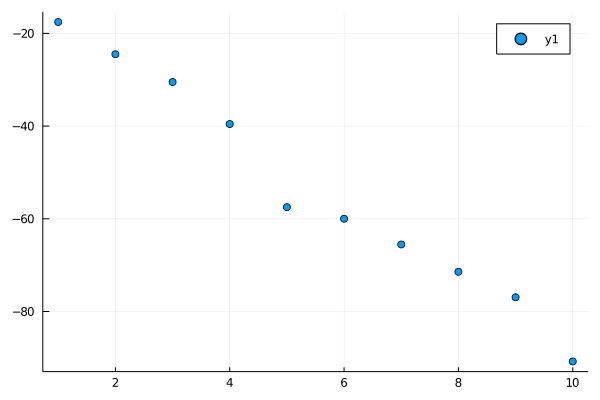

In [17]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [18]:
# gap after 4
nev = 4
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [19]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmins =     [-2, -2, -2, -2]
cmaxs =     -1 .* cmins
cmins_lr =  [-0.5, -0.5, -0.5, -0.5]
cmaxs_lr =  -1 .* cmins_lr;

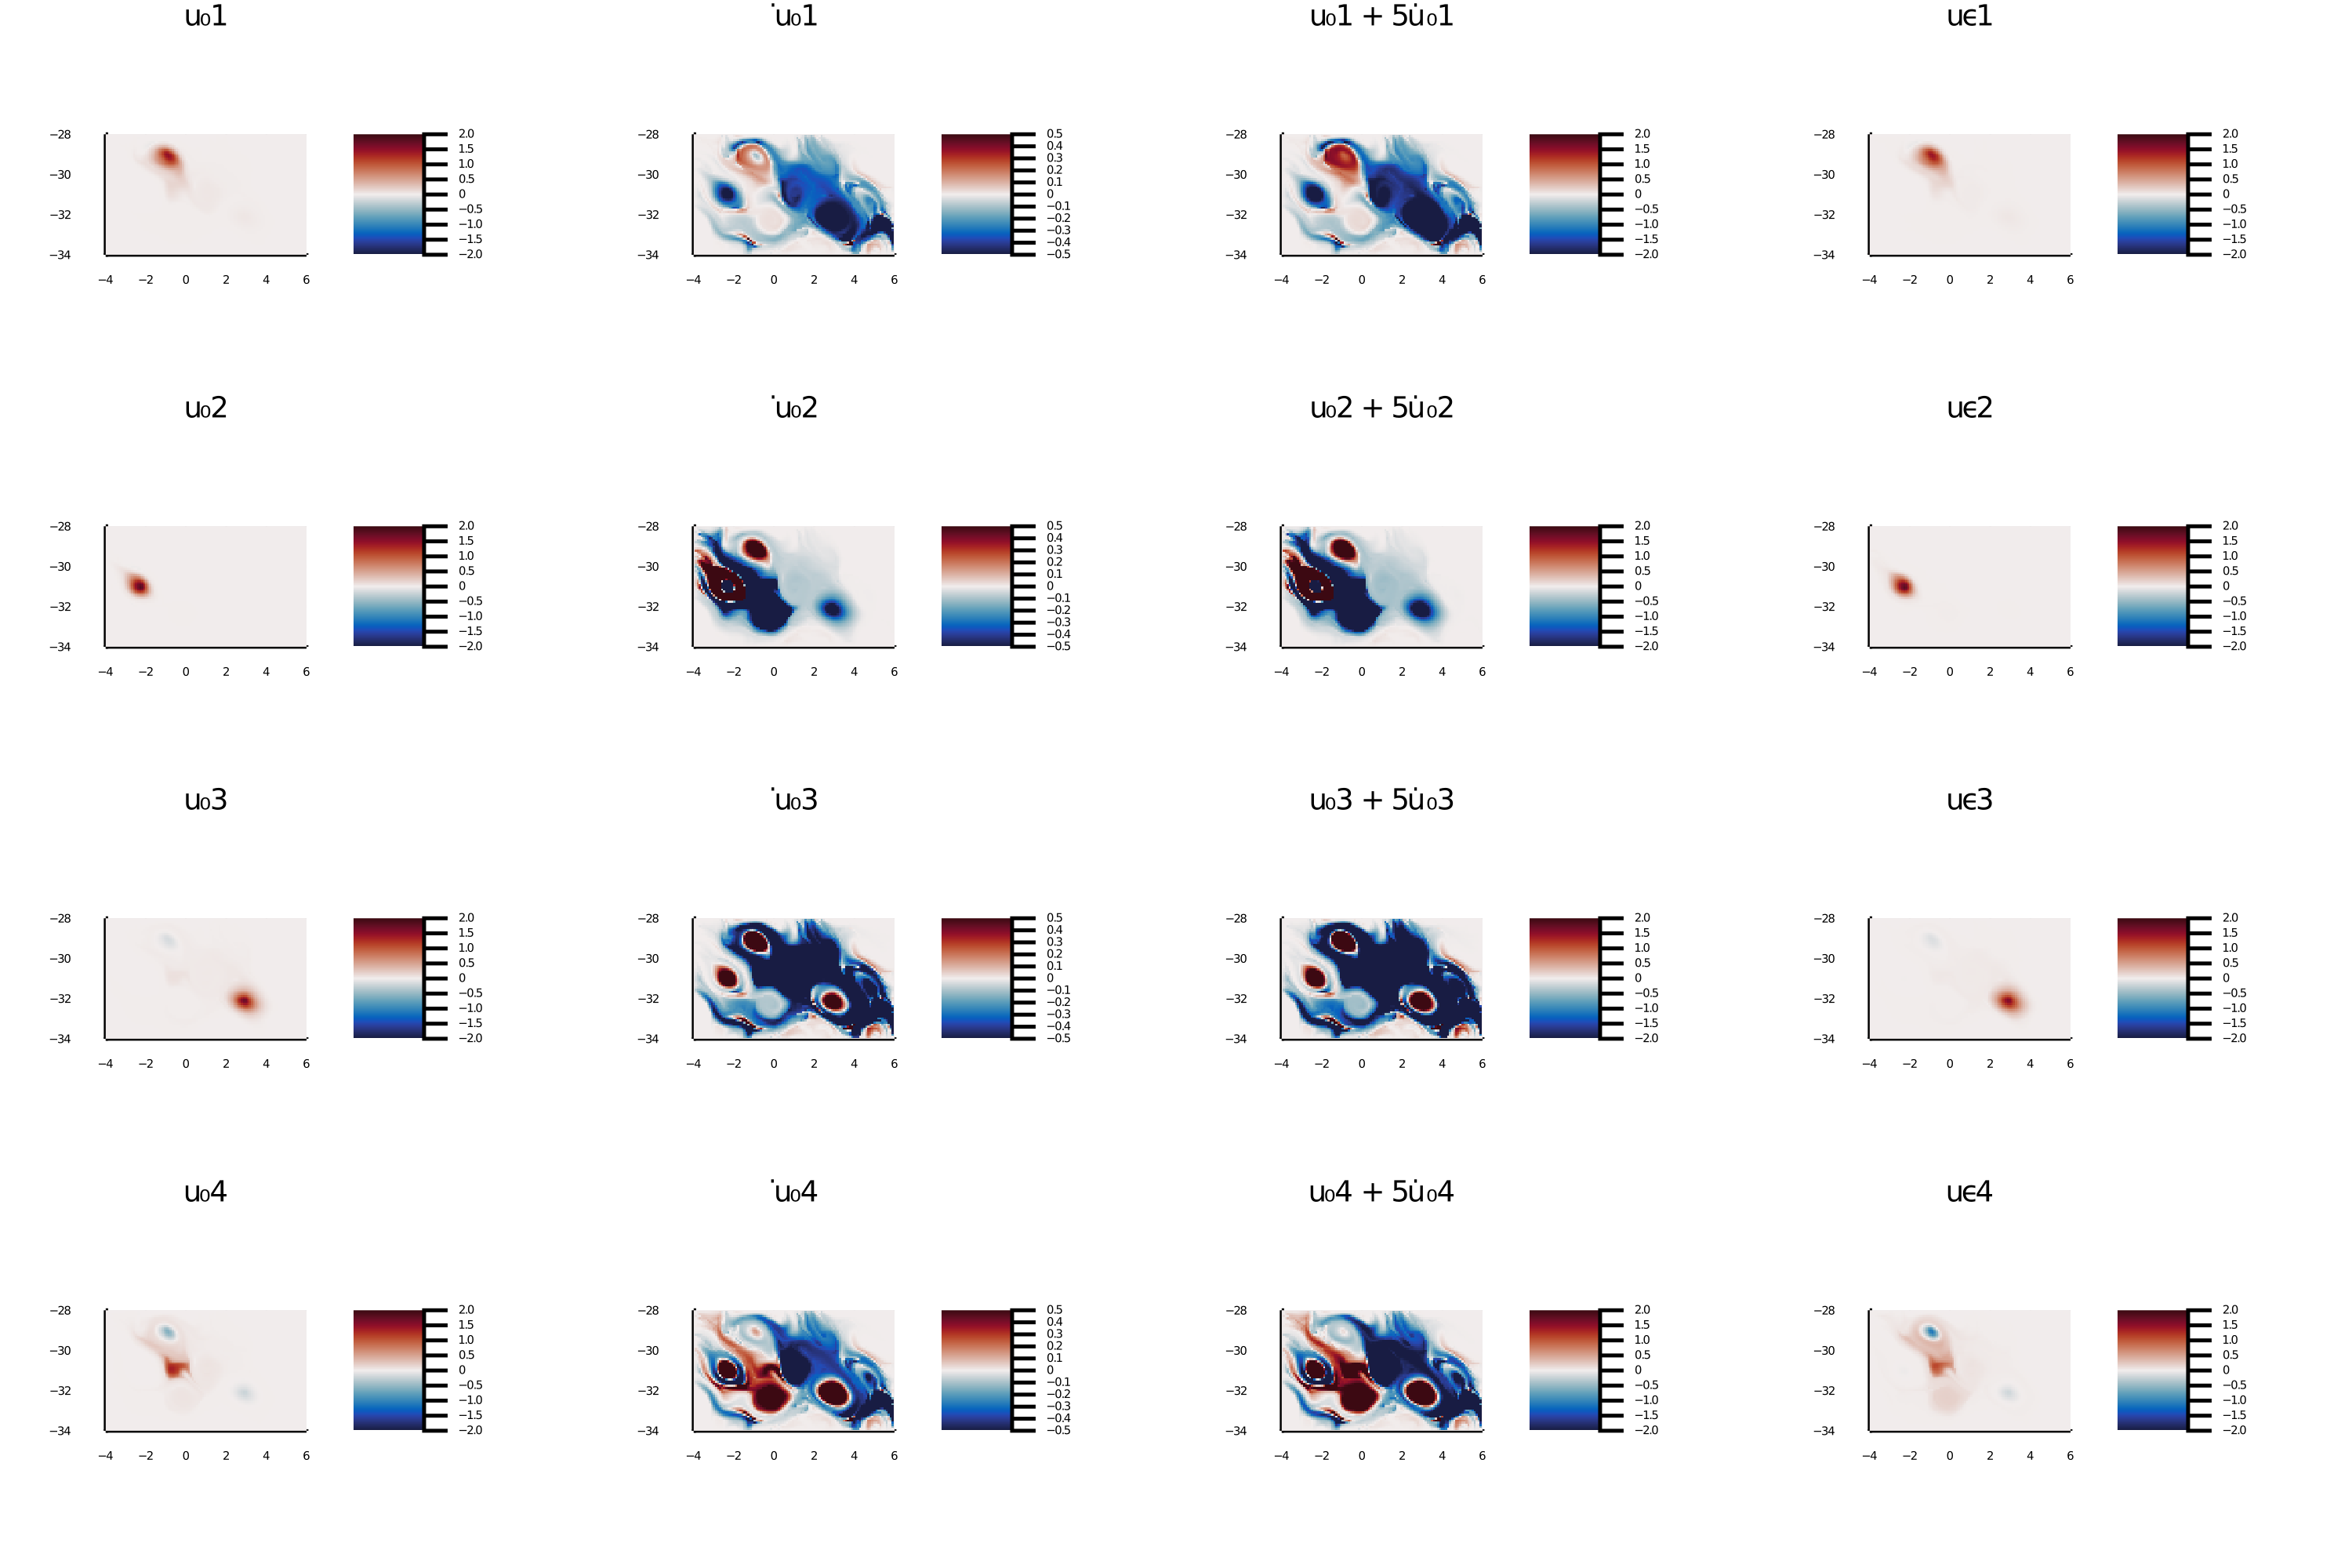

In [20]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i], lon_resolution, lat_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [21]:
# reorder where neccessary
#uϵ = uϵ[:,[1,2,4,3]];

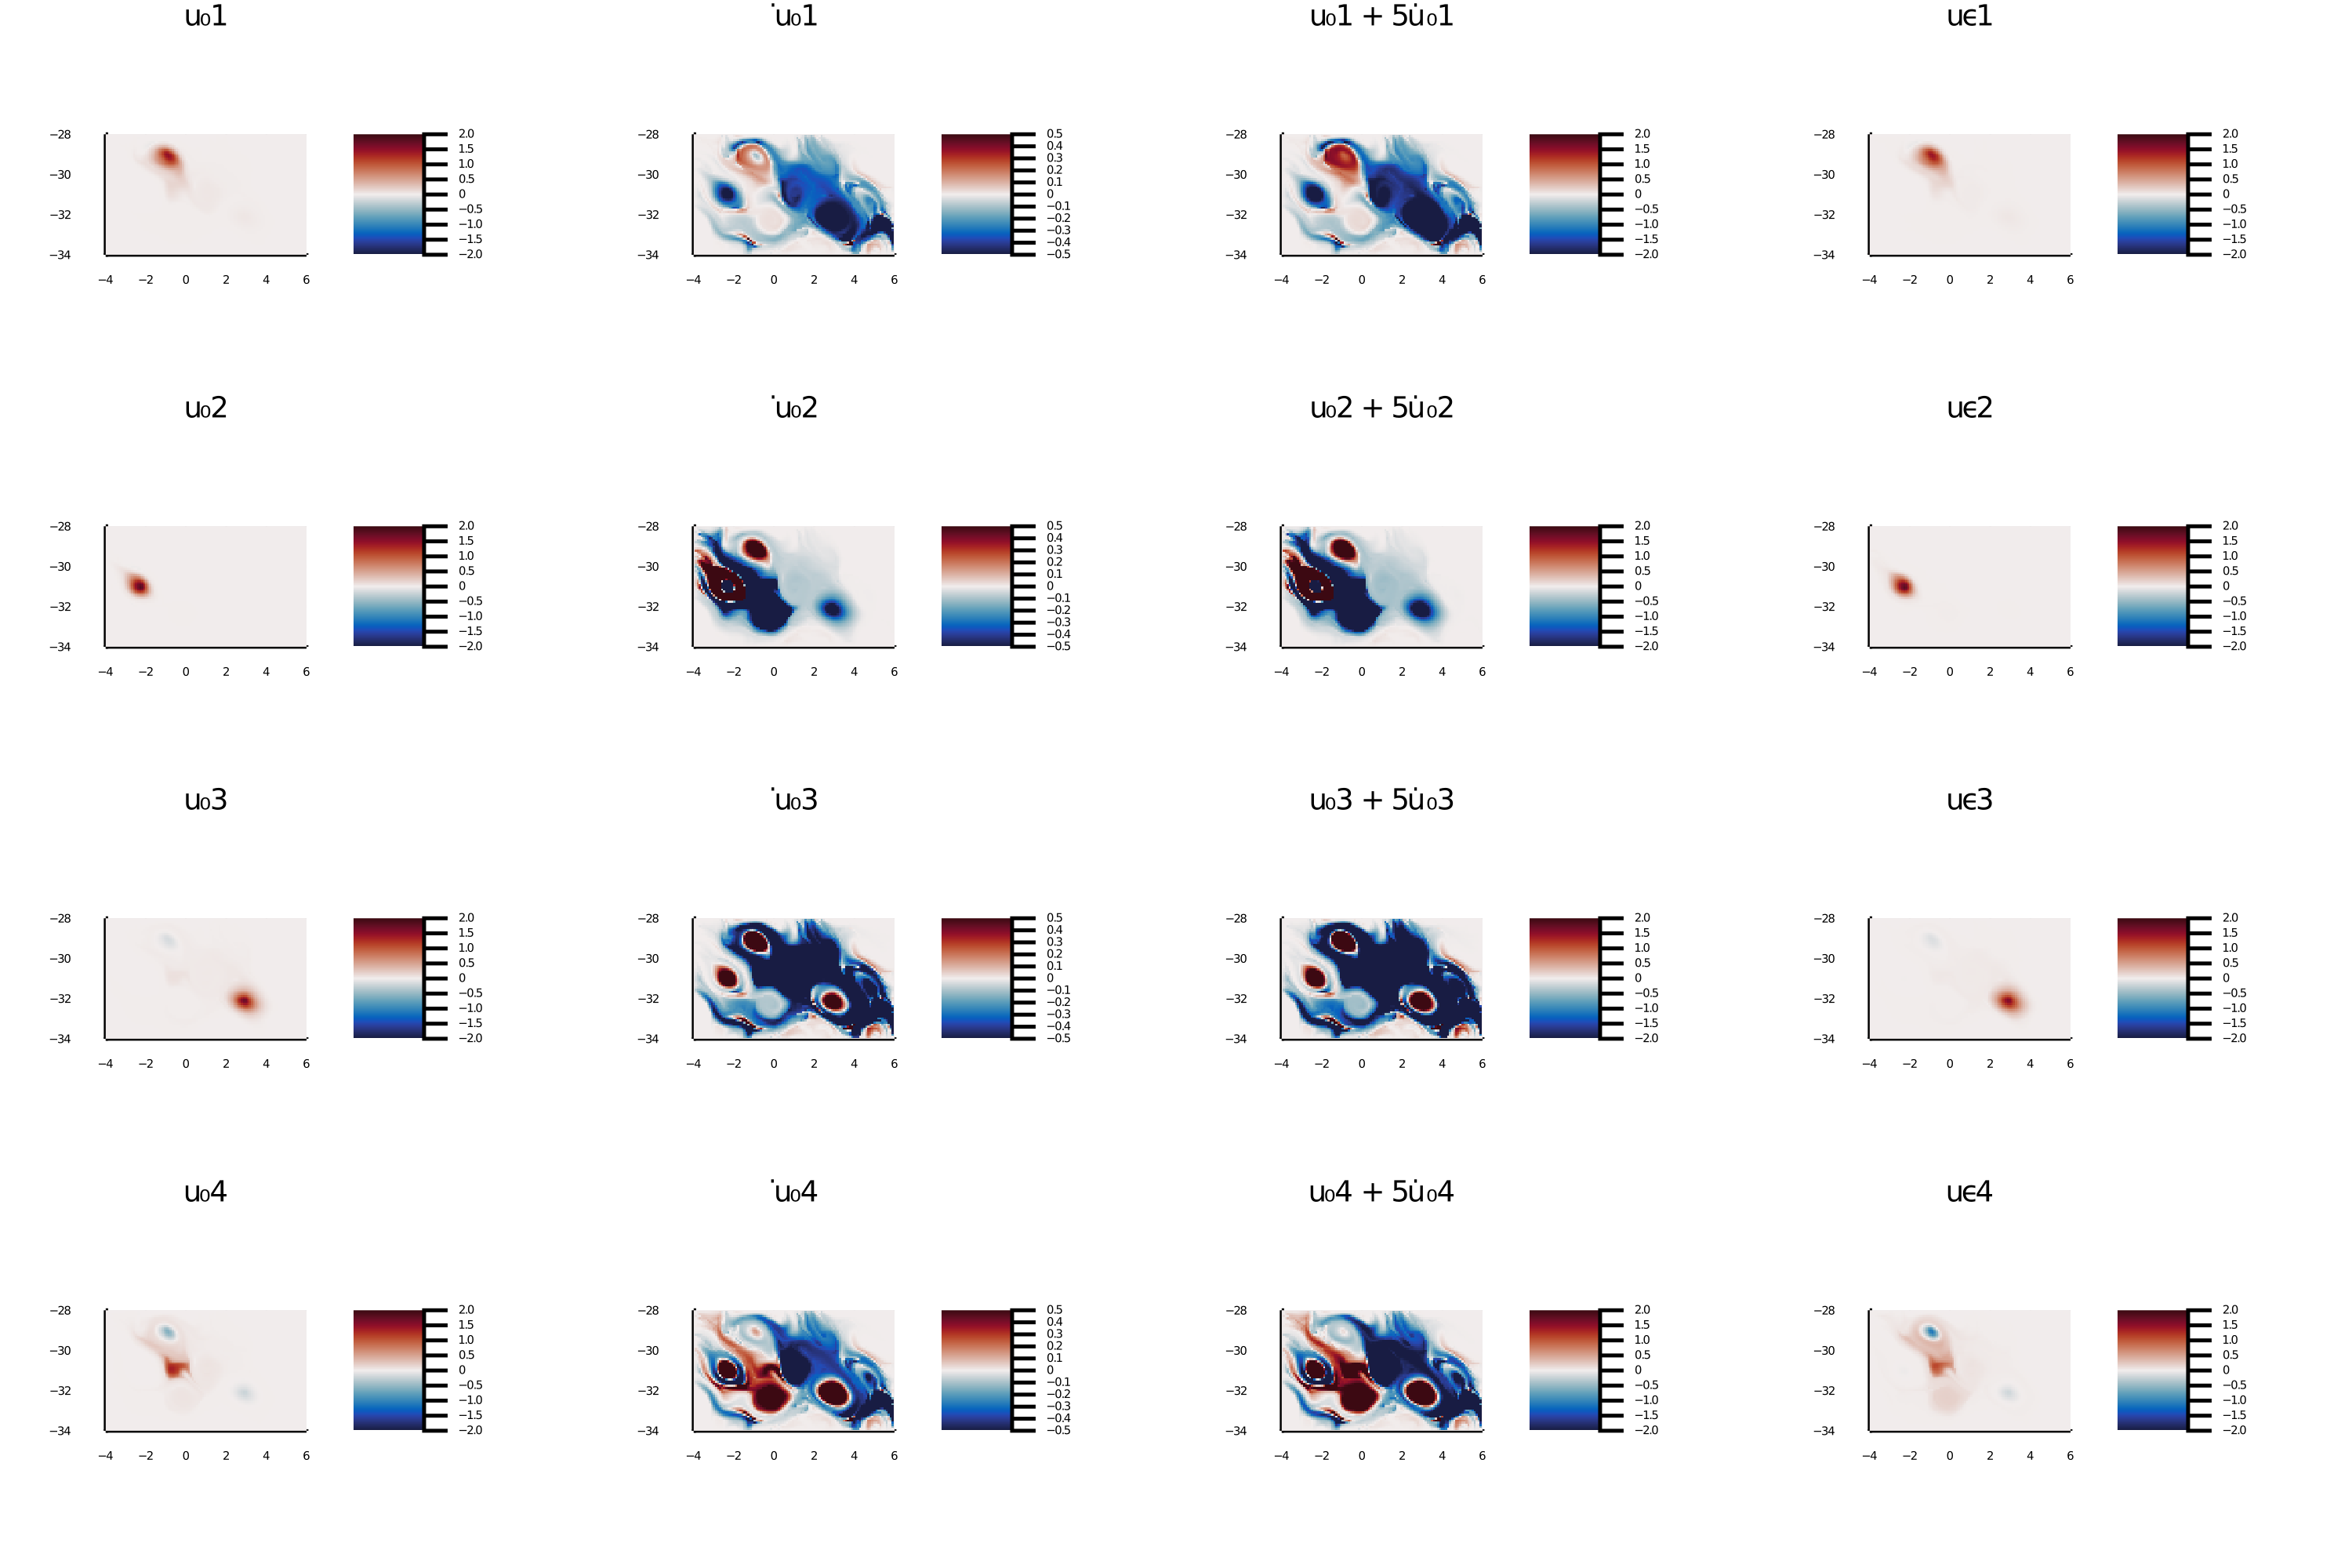

In [22]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i], lon_resolution, lat_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [23]:
using Contour
using StaticArrays

In [24]:
#Contour.jl needs StaticArrays
T_static(x) = SVector{2,Float64}(T(x,0))

T_static (generic function with 1 method)

In [25]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T_static(x),tolerance=1e-10)
end

dynamic_cheeger_value_levelset (generic function with 1 method)

In [26]:
ev = 2;

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.02755136159440692)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.025669571997135734)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.023787782399864545)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.02190599280259336)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.02002420320532217)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.016260624010779795)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.01437883441350861)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.012497044816237422)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0106152

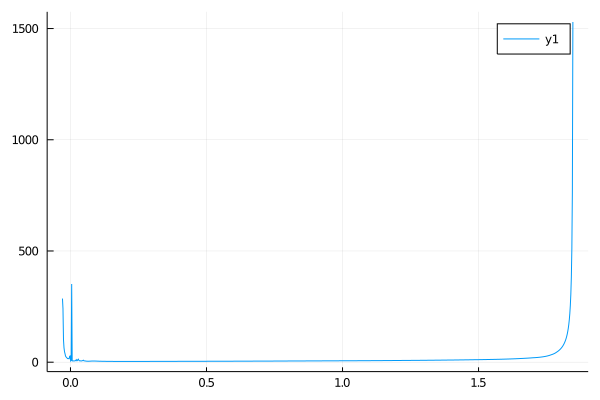

In [27]:
u_max = maximum(u₀[:,ev])
u_min = minimum(u₀[:,ev])
values = []
for c in range(u_min,stop=u_max,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c, bdata=bdata)
    if (length(lines(levelset))>0)
        push!(values,dynamic_cheeger_value_levelset(levelset))
    else 
        push!(values,0)
    end
end
Plots.plot(range(u_min,stop=u_max,length=1000)[2:end-1],values[2:end-1])

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.027558881233157258)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.025680851455261236)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.023802821677365218)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0219247918994692)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.020046762121573178)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.01629070256578114)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.014412672787885121)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.012534643009989101)
└ @ Main In[25]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.010656

Dynamic Cheeger value:	3.4402495036776246
Levelset:		0.18653651344698893
3.4402495036776246	4.286935026860311	5.041014536963044	1.3557082929380244


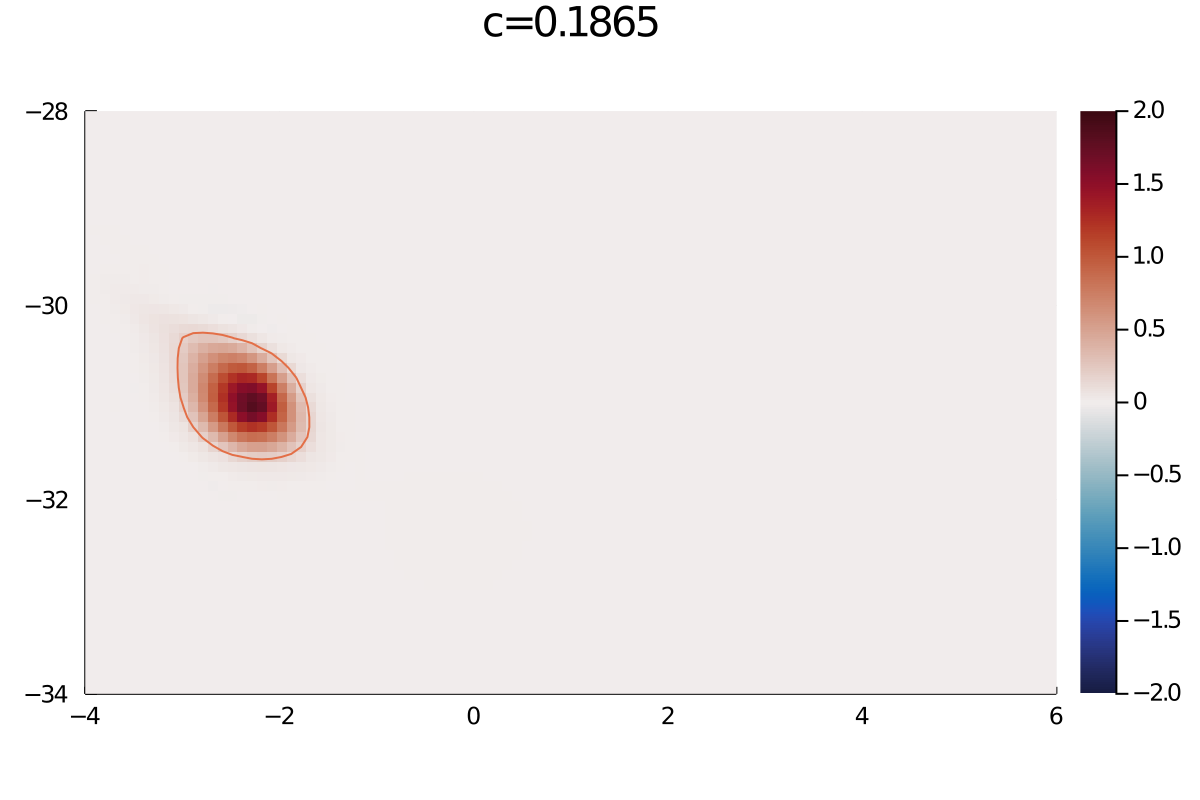

In [28]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value_levelset,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀[:,ev], c_best, bdata=bdata))
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(-4,6), ylims=(-34,-28))

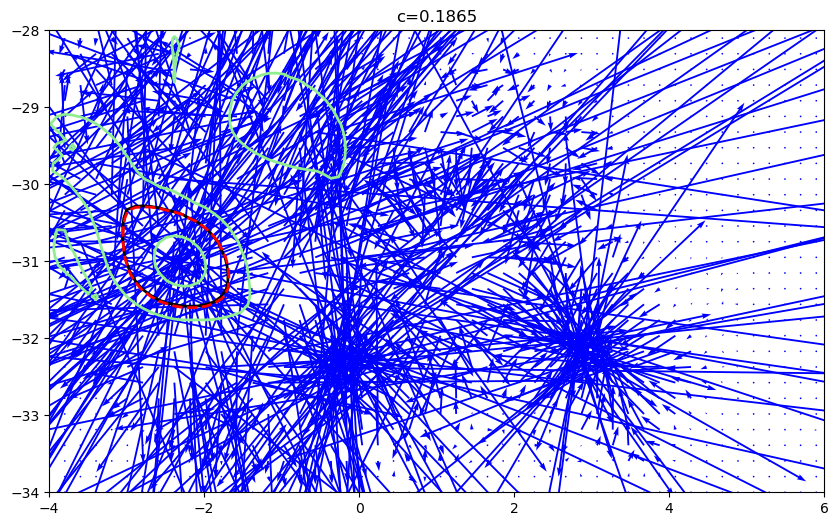

In [29]:
using PyCall
using PyPlot
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev], bdata=bdata)...,ax,scale=1,step=2)
curves           = lines(get_levelset(ctx, u₀[:,ev], c_best, bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev], c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev], c_best, bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

## SEBA

In [30]:
μ = 0.99/sqrt(lon_resolution*lat_resolution);

In [31]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false);

  1.503019 seconds (6.32 M allocations: 335.363 MiB, 4.39% gc time)


In [32]:
inv(qr(u₀).R)*R'

4×4 Array{Float64,2}:
 -0.0998402   -1.04574e-5  -0.00469036  -0.012832
 -1.31994e-5   0.100514    -1.33144e-5   2.28279e-5
  0.00576738  -9.41834e-6  -0.100162    -0.00899359
  0.0119394    2.93966e-5   0.00960148  -0.0990817

In [33]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [34]:
Sprime = Matrix(qr(u₀).Q)*R';

In [35]:
Sdot = u_dot*inv(qr(u₀).R)*R';

In [36]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [37]:
Sϵprime = Matrix(qr(uϵ).Q)*Rϵ';

##### Compare different ways to arrive at a similar result

In [38]:
cmins = [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
cmaxs = -1 .* cmins
cmins_lr = [-.4, -.4, -.4, -.4, -.4, -.4, -.4, -.4, -.4]
cmaxs_lr = -1 .* cmins_lr;

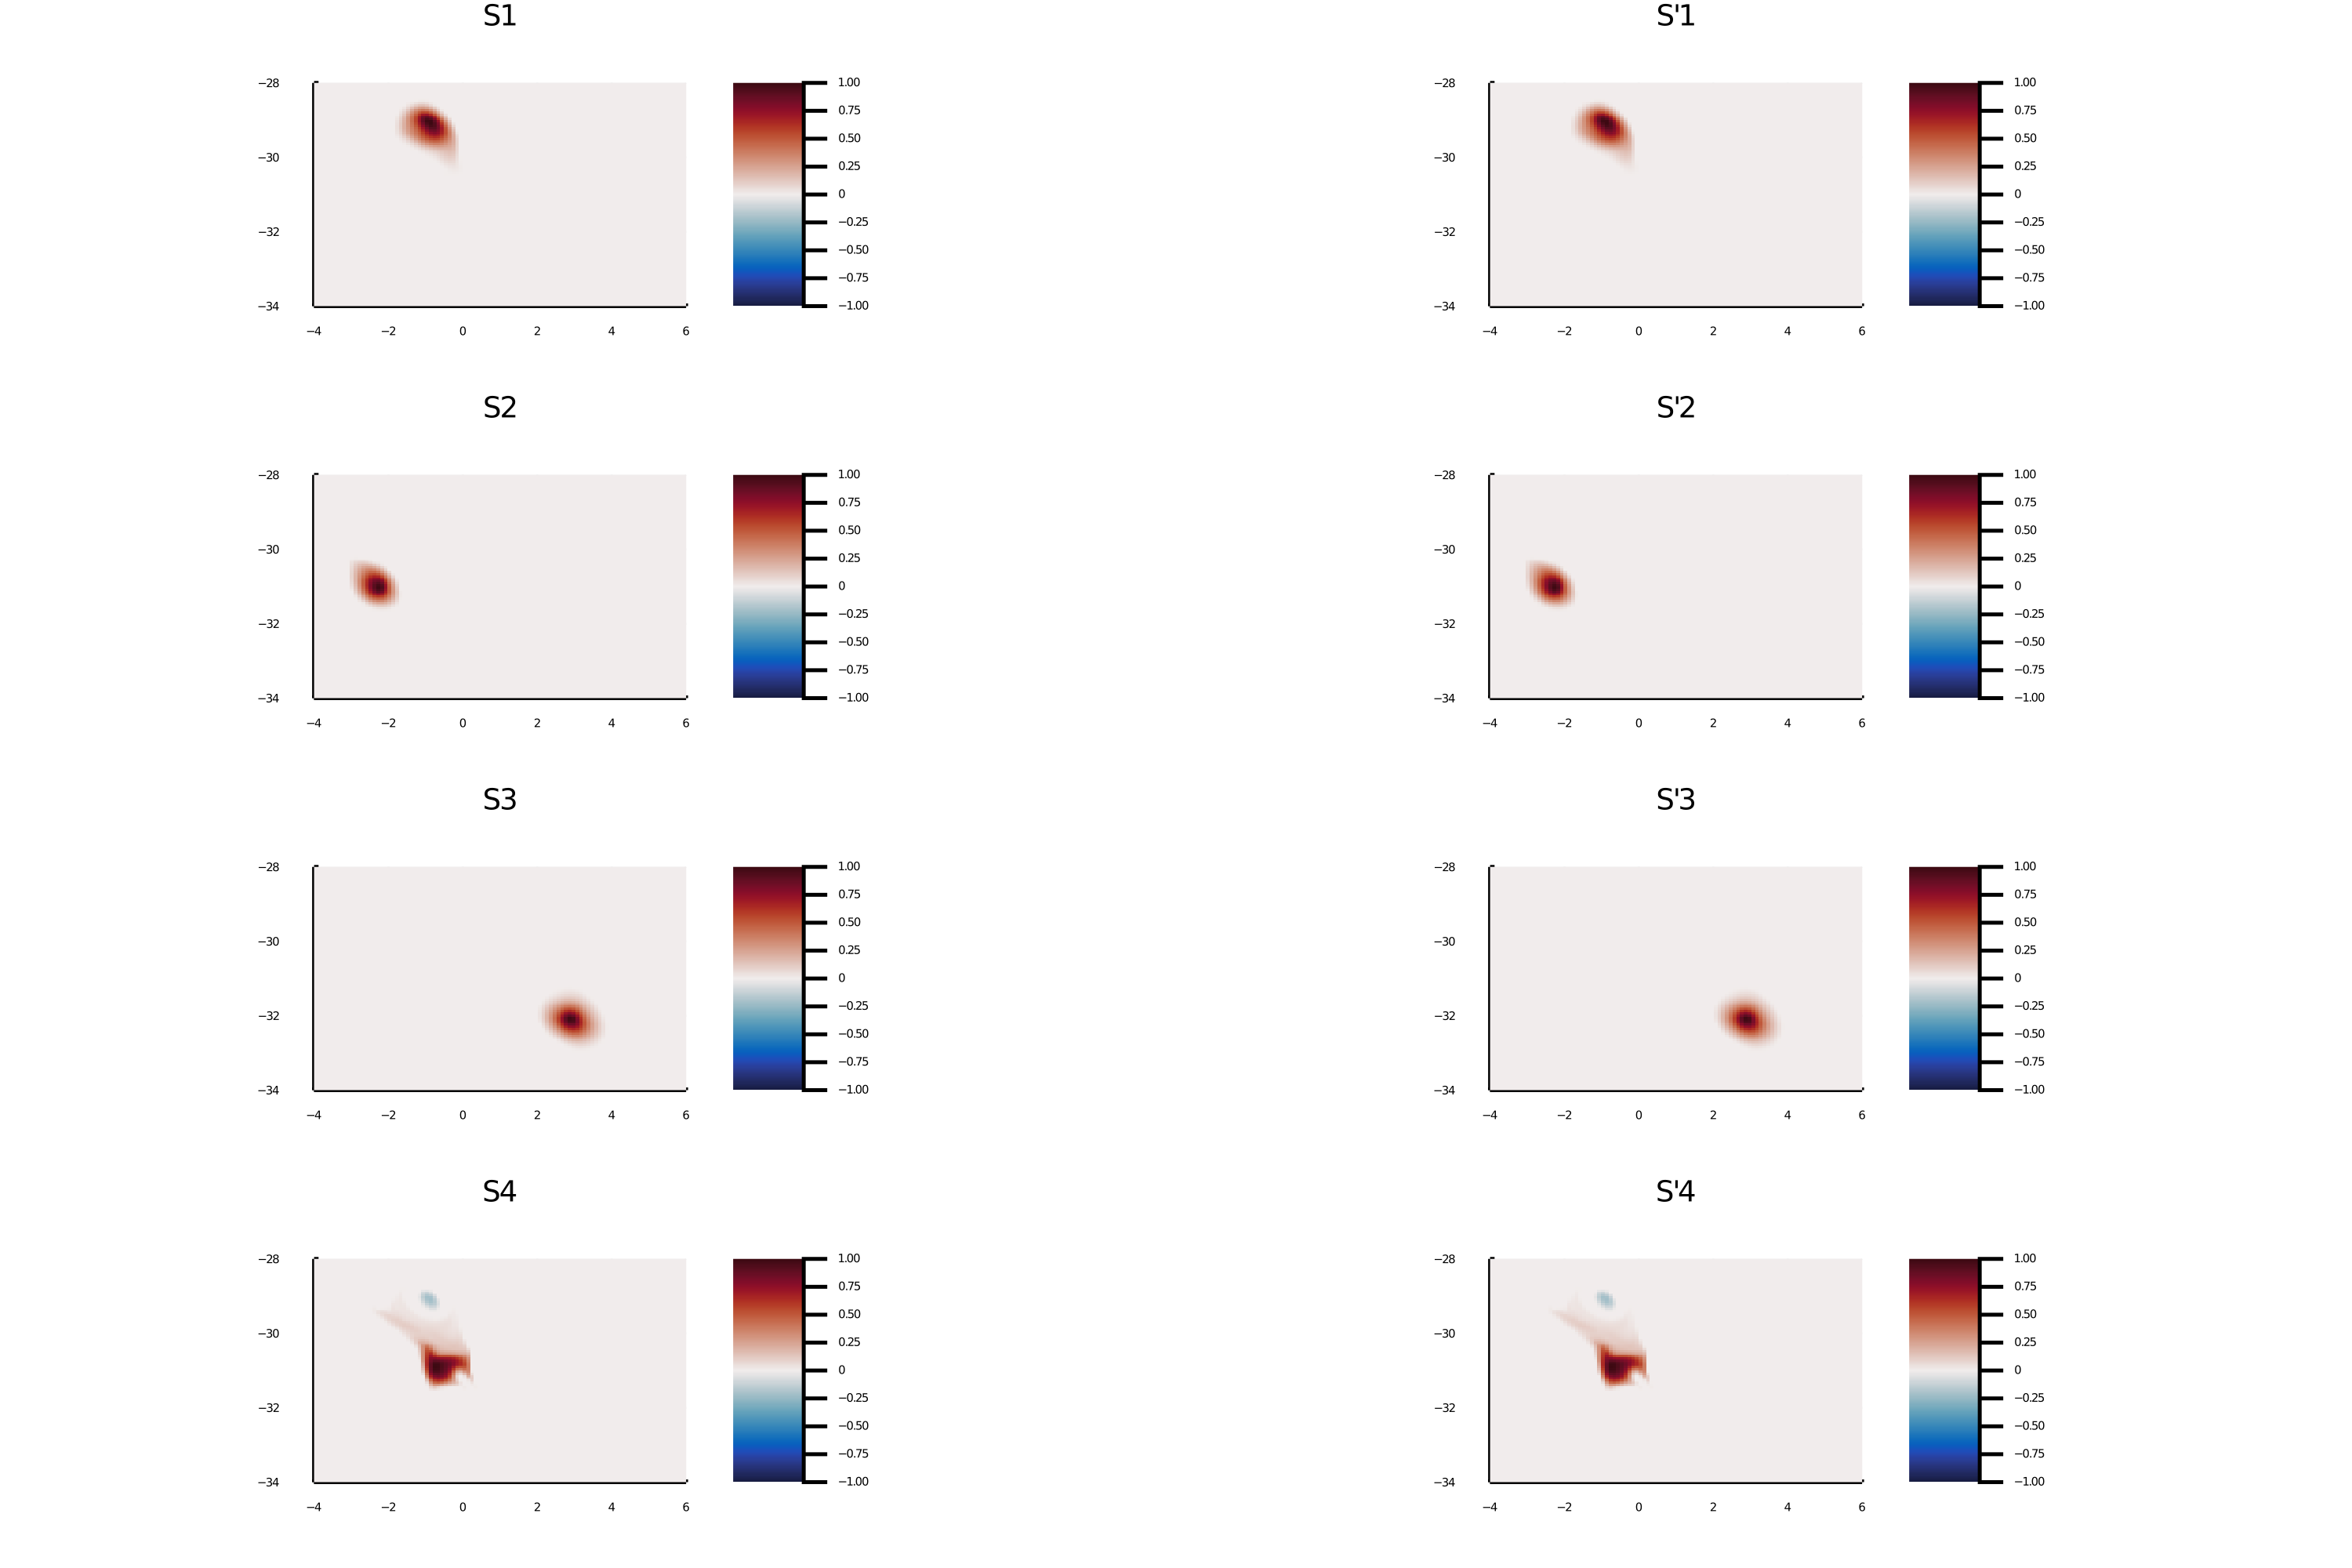

In [39]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="S"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sprime[:,i],μ)), grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

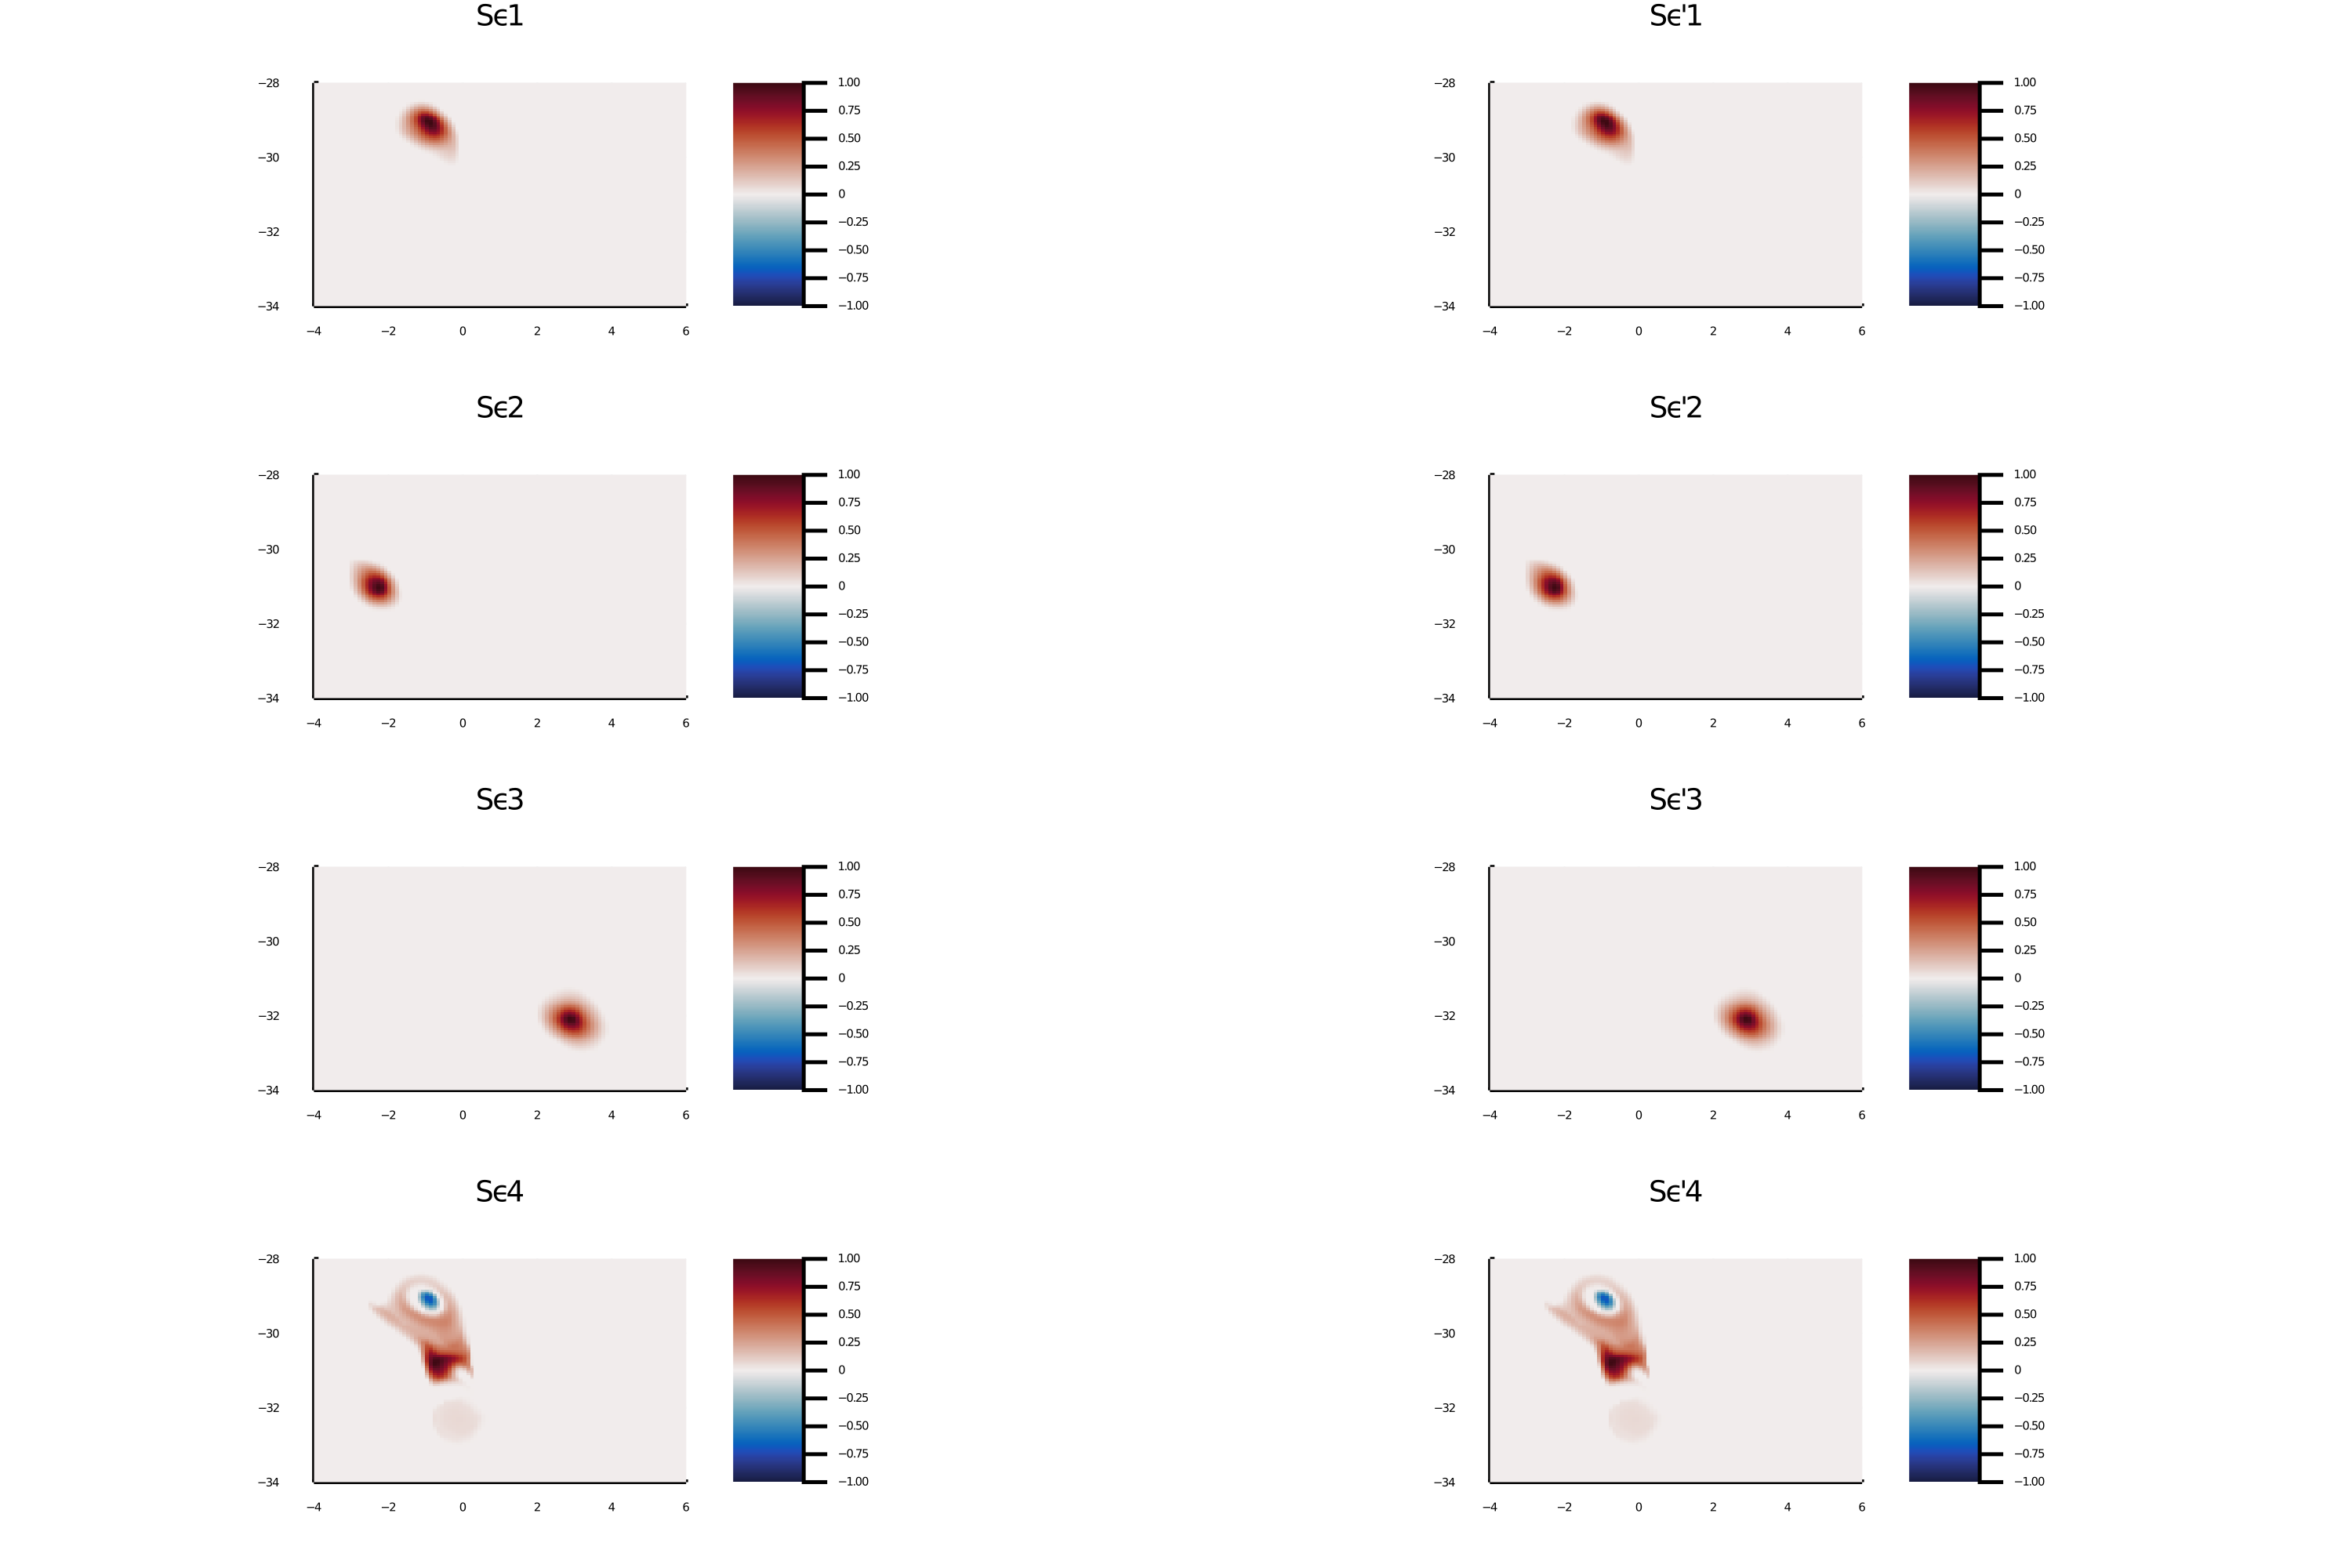

In [40]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, Sϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sϵprime[:,i],μ)), grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

### Prediction

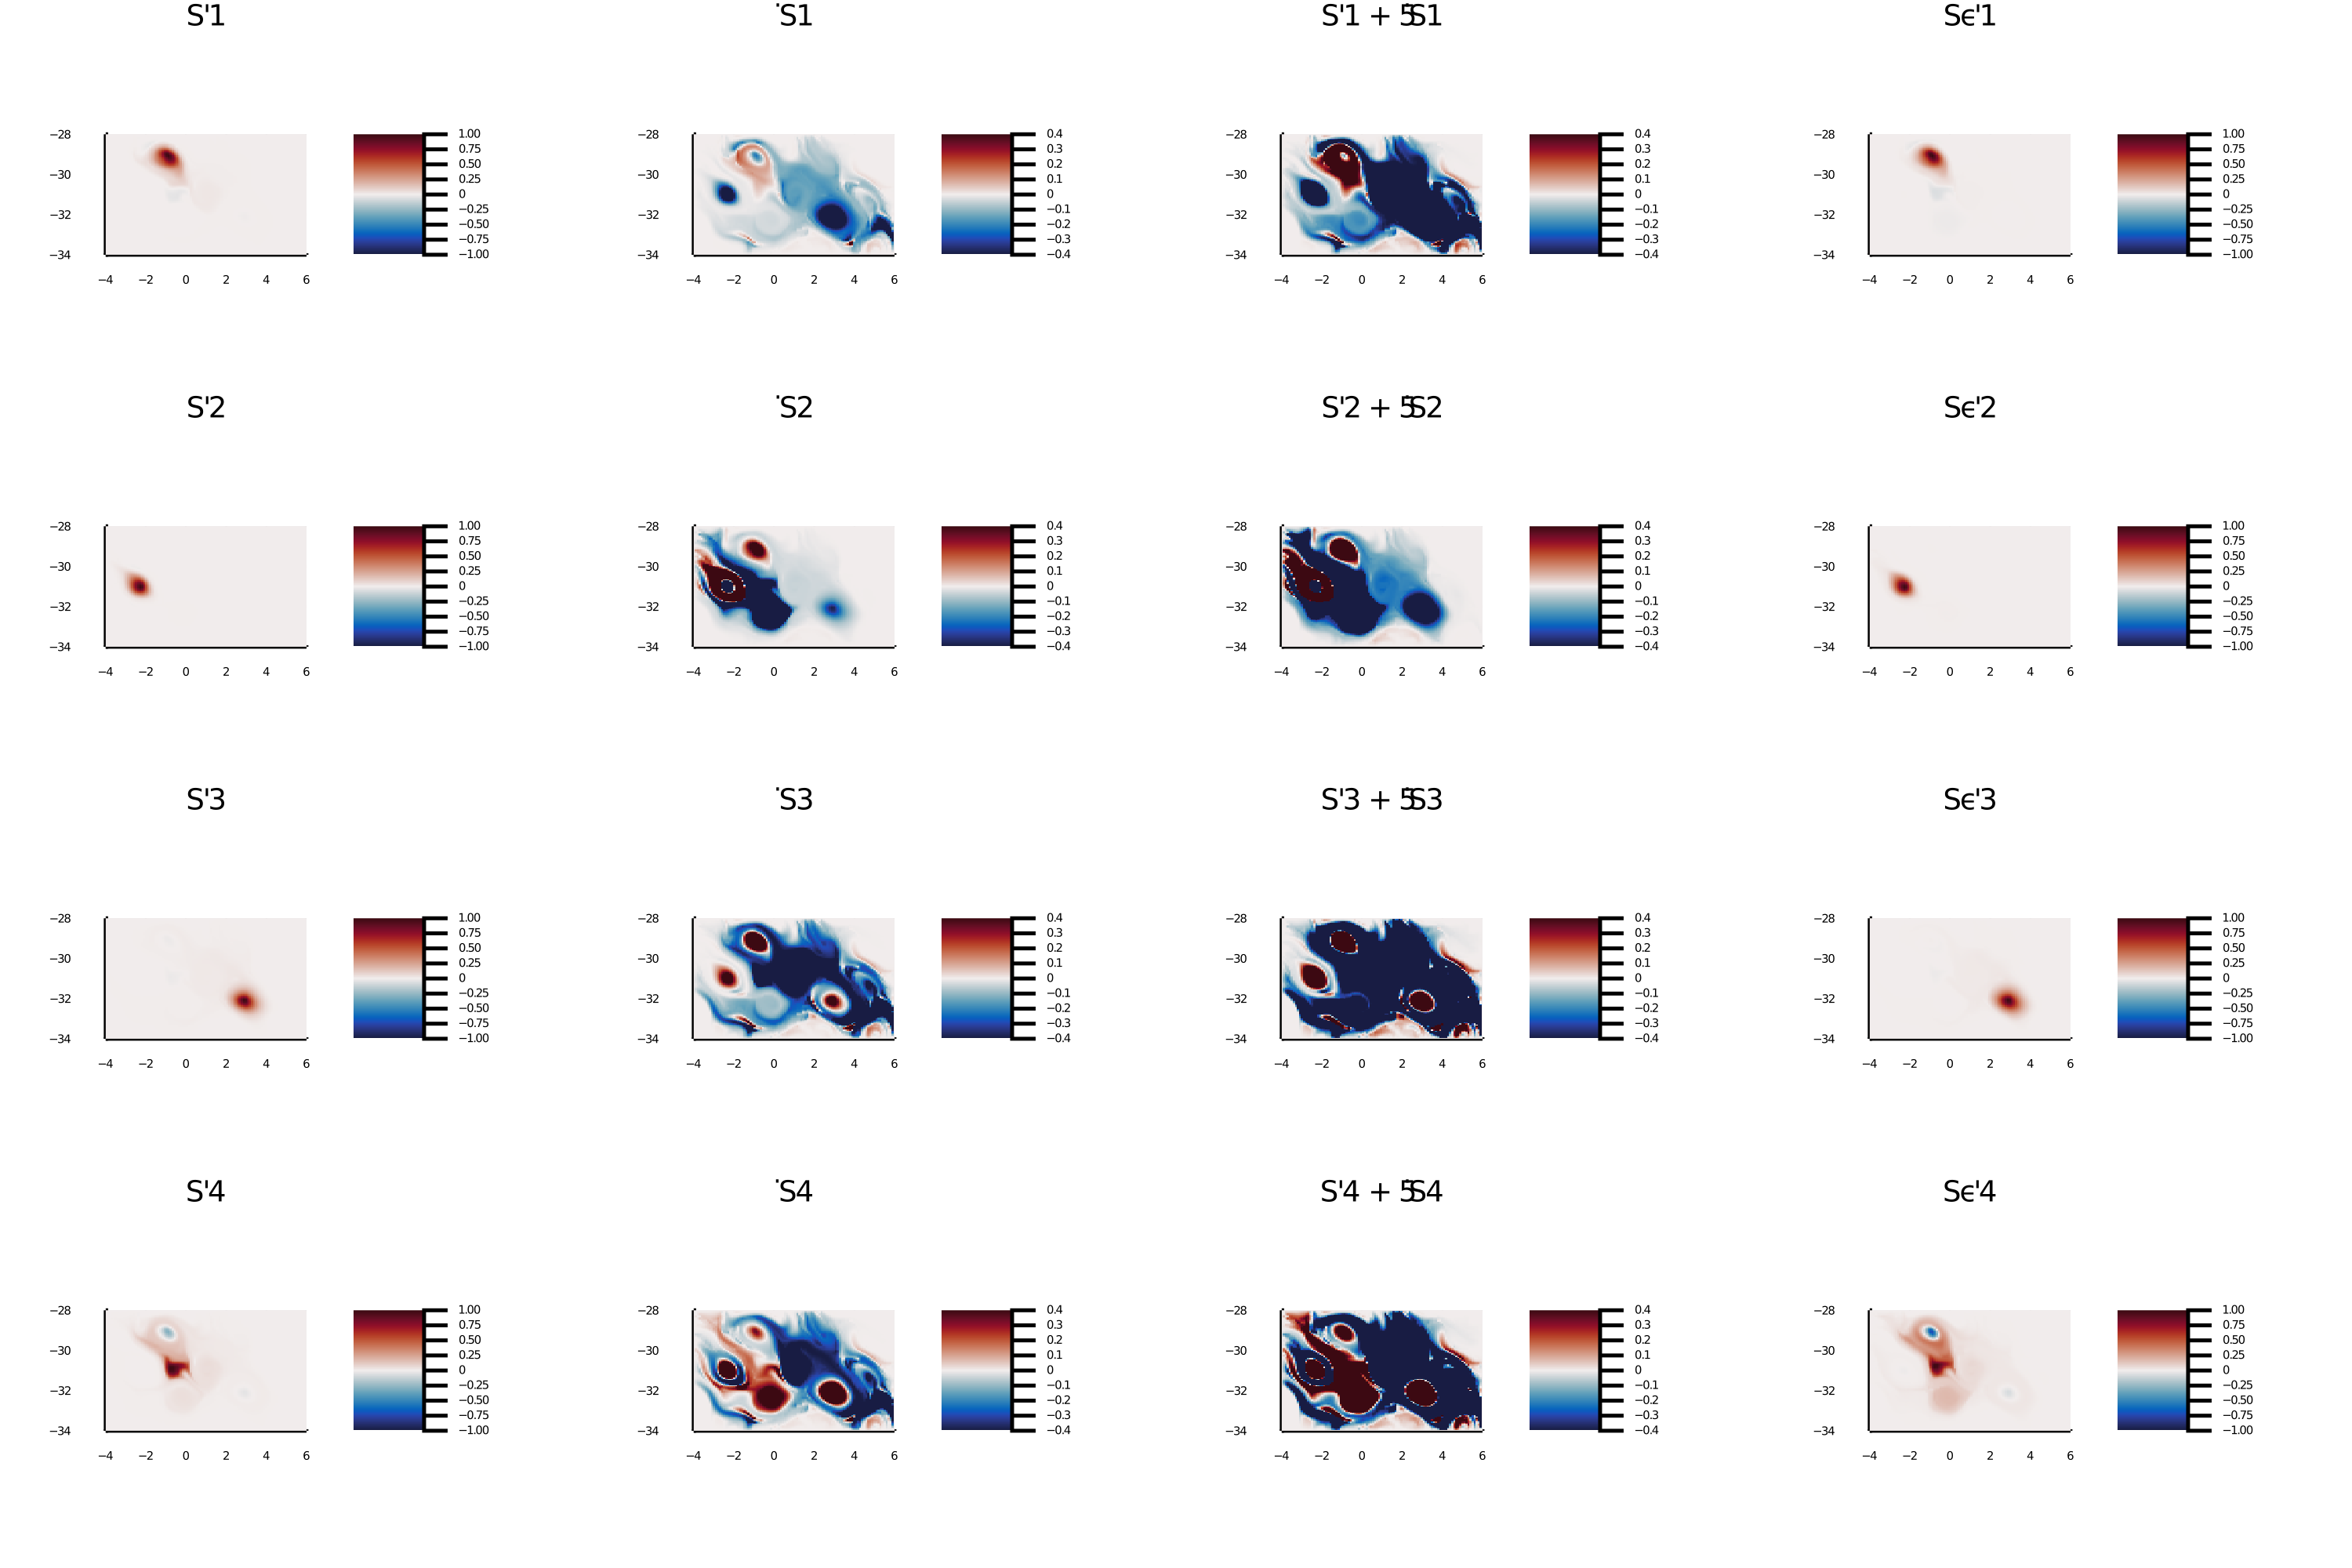

In [41]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="̇S"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sprime[:,i] + ϵ*Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i)*" + $(ϵ)̇S"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

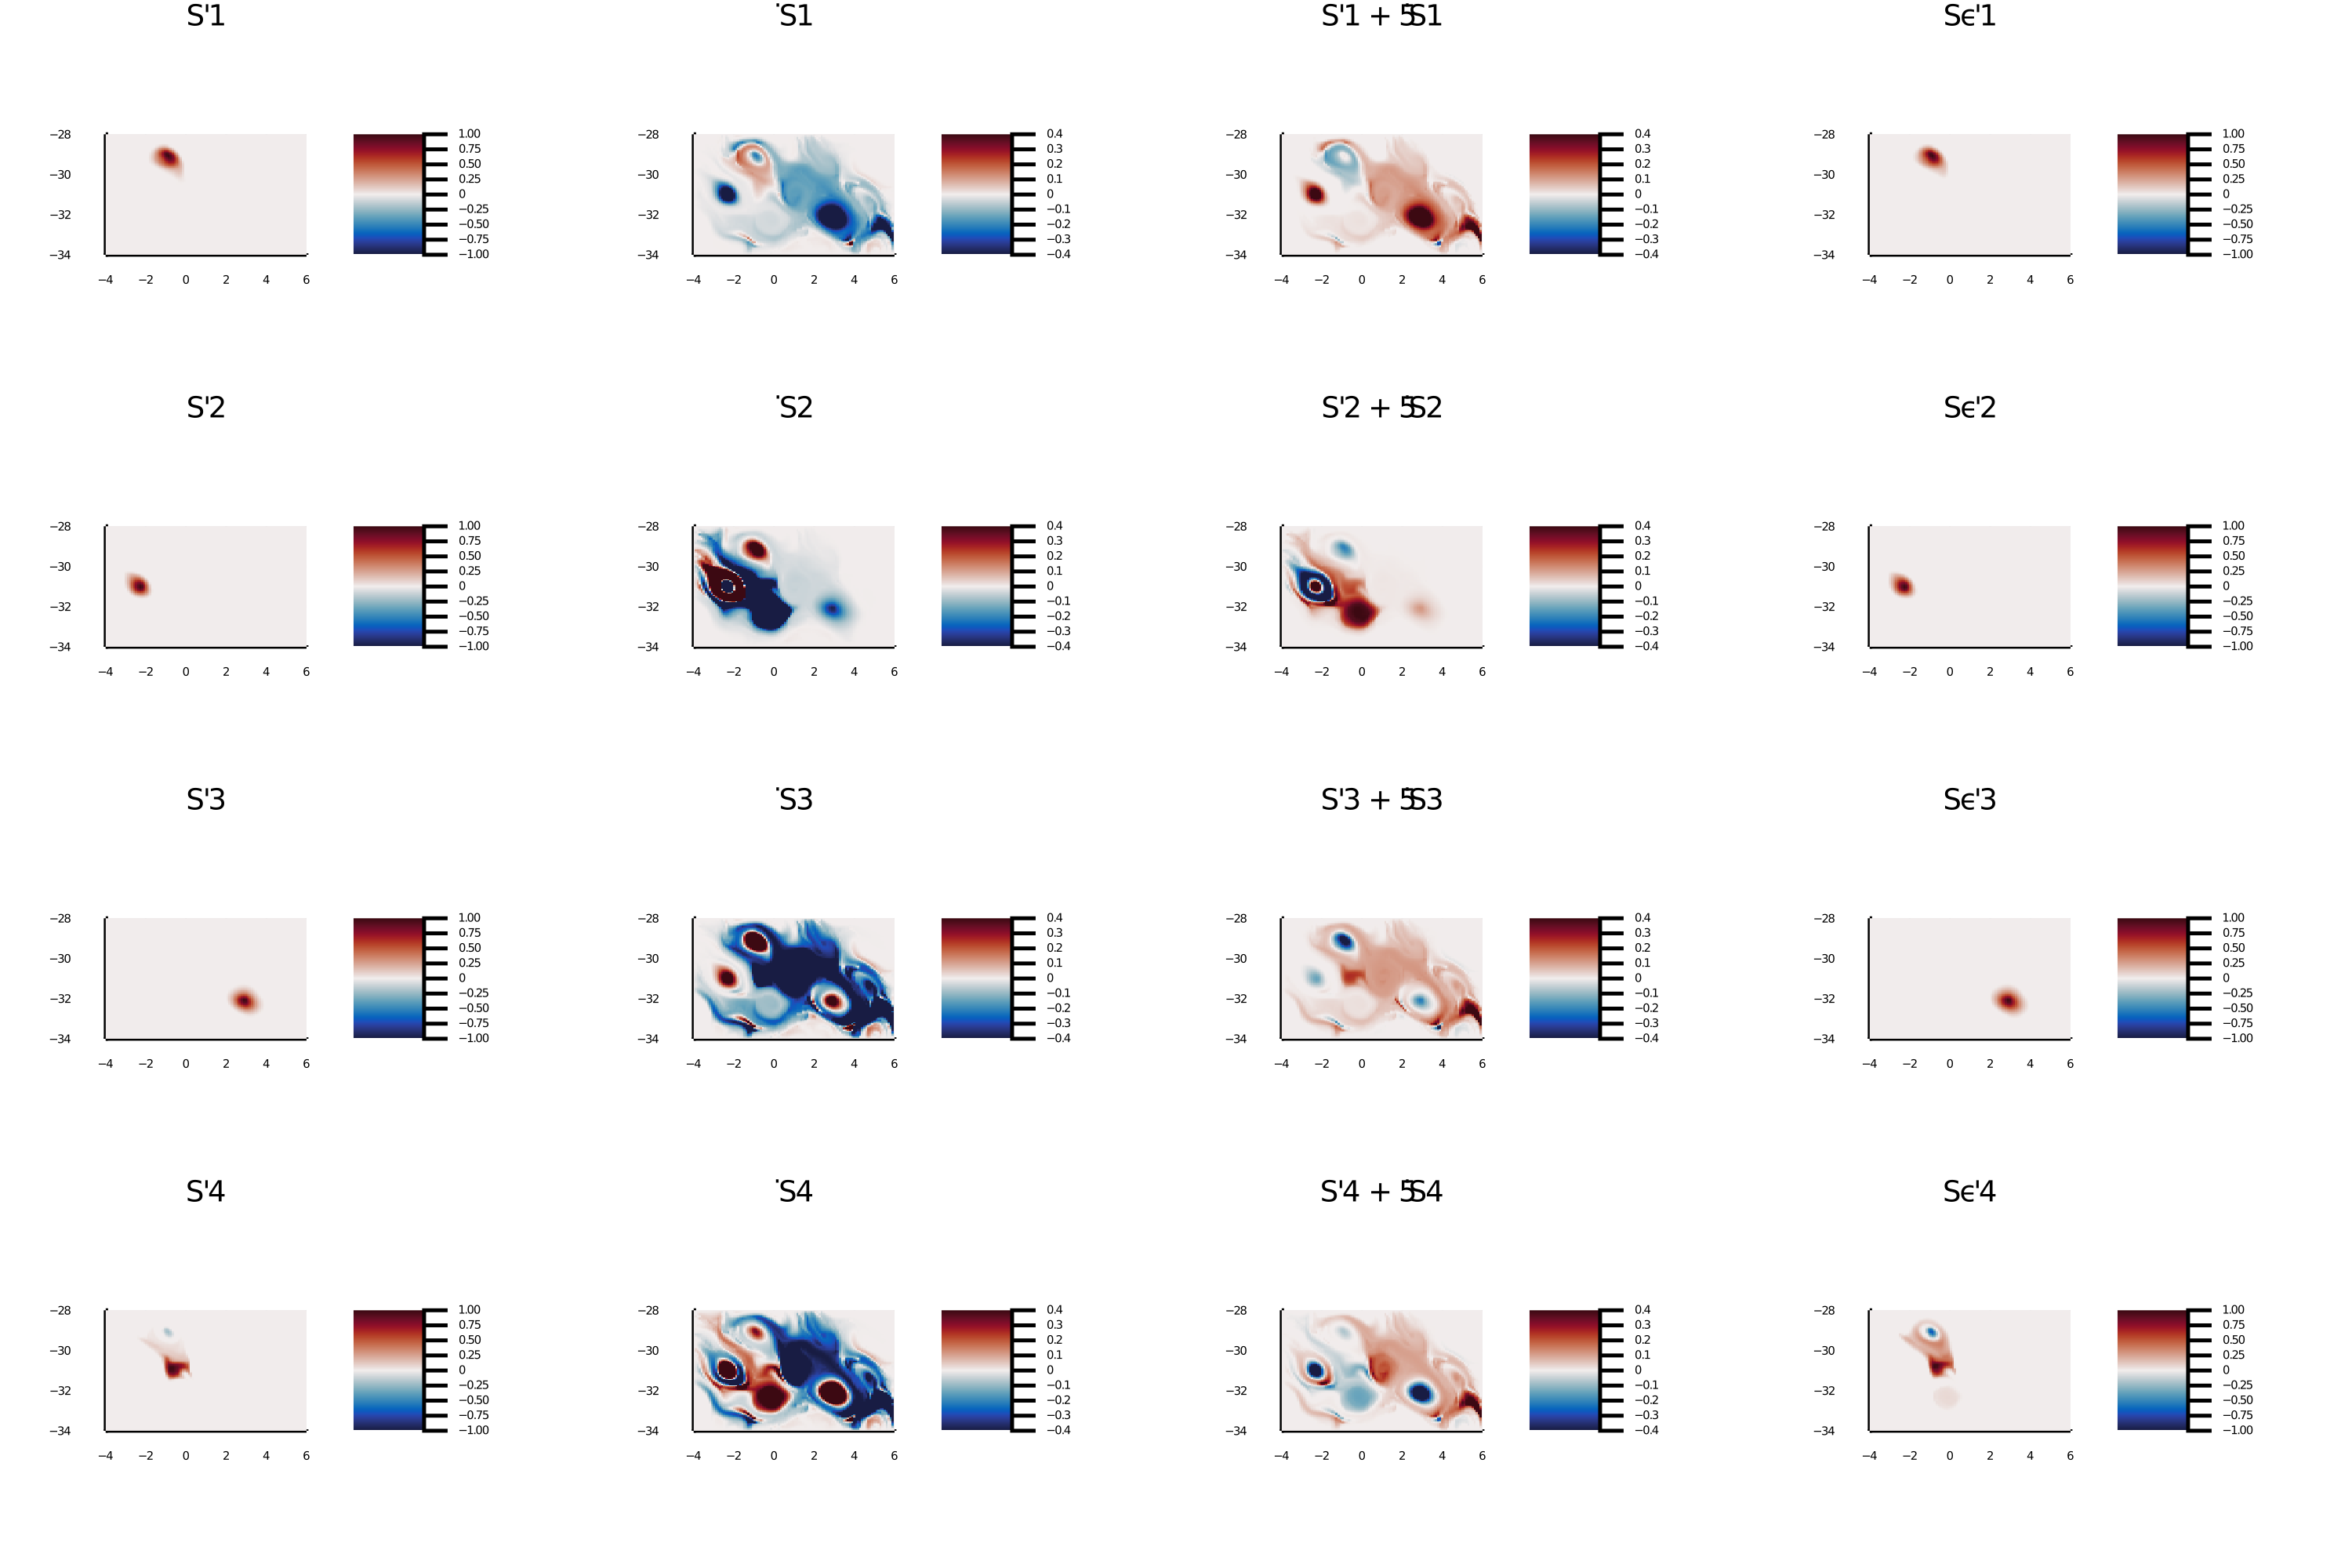

In [42]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="̇S"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sprime[:,i] + ϵ*Sdot[:,i],μ)),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i)*" + $(ϵ)̇S"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [43]:
ev = 2;

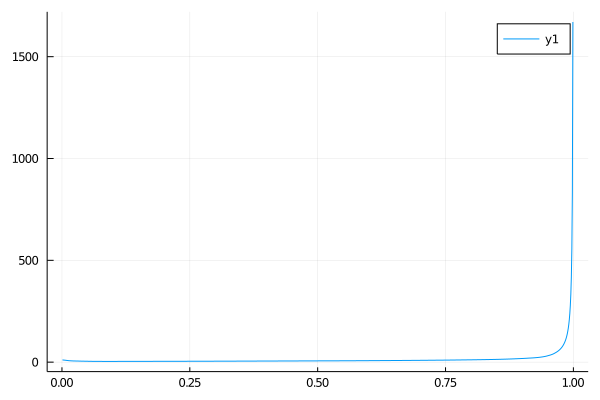

In [44]:
u_max = maximum(S[:,ev])
u_min = minimum(S[:,ev])
values = []
for c in range(u_min,stop=u_max,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c, bdata=bdata)
    if (length(lines(levelset))>0)
        push!(values,dynamic_cheeger_value_levelset(levelset))
    else 
        push!(values,0)
    end
end
Plots.plot(range(u_min,stop=u_max,length=1000)[2:end-1],values[2:end-1])

Dynamic Cheeger value:	3.5200824884341206
Levelset:		0.08991008991008986
3.5200824884341206	3.904943090978308	4.131755599832208	1.141549767259229


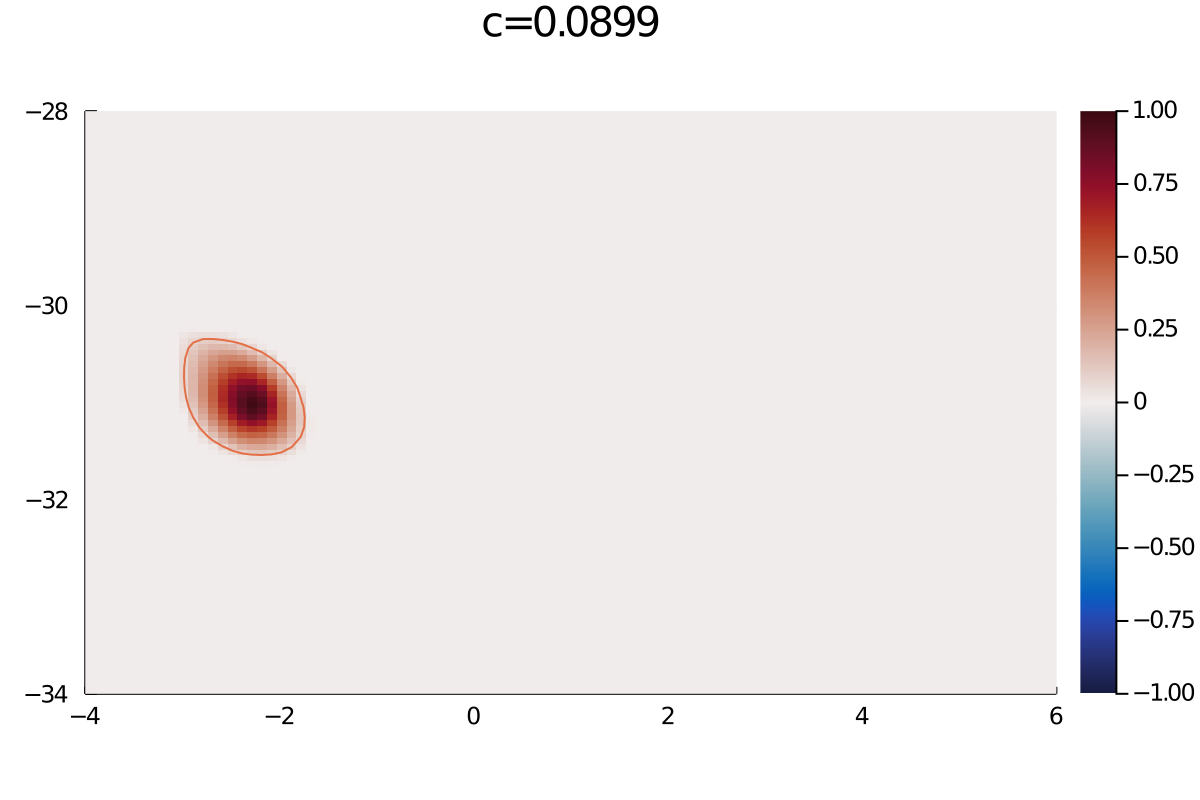

In [45]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value_levelset,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, S[:,ev], c_best, bdata=bdata))
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(-4,6), ylims=(-34,-28))

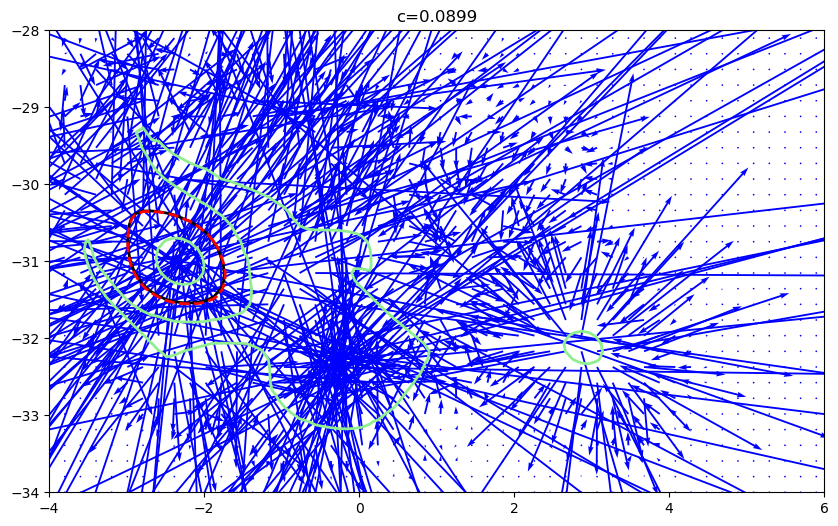

In [46]:
using PyCall
using PyPlot

plt.figure(figsize=(7,7), dpi=100)
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(
                get_levelset_evolution(ctx,normalizeU(Sprime[:,ev]),normalizeU(Sdot[:,ev],Sprime[:,ev]),bdata=bdata)...,
                ax,scale=1,step=2)
curves           = lines(get_levelset(ctx, S[:,ev], c_best, bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev], c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(Sprime[:,ev] + ϵ*Sdot[:,ev],μ)), c_best, bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");